# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! In this tutorial, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial or use "File -> Open in playground mode" to play with it yourself.


# Install detectron2

In [0]:
# install dependencies:
# (use +cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

In [0]:
import torch, torchvision
torch.__version__
!gcc --version

In [4]:
# install detectron2:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

In [5]:
%cd detectron2_repo/

/content/detectron2_repo


In [6]:
!nvidia-smi


Sun Apr  5 08:50:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Run a pre-trained detectron2 model

We first download a random image from the COCO dataset:

In [0]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -O input.jpg
im = cv2.imread("input.jpg")
cv2_imshow(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [9]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

model_final_c10459.pkl: 184MB [00:03, 46.4MB/s]                           


In [0]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
outputs["instances"].pred_classes
outputs["instances"].pred_boxes

In [0]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the balloon segmentation dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon)
which only has one class: balloon.
We'll train a balloon segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have the "balloon" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

In [11]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [13]:
!ls drive/My Drive/

ls: cannot access 'drive/My': No such file or directory
ls: cannot access 'Drive/': No such file or directory


In [0]:
!unzip -q '/content/drive/My Drive/Steel-defect-detection/Steel.zip'

In [0]:
!rm -rf '/balloon'

Register the balloon dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. See the tutorial for more details.


#Mask visualization

In [0]:

import numpy as np 
import pandas as pd
import random as rn
import cv2 as cv 
import os
import sys
from pathlib import Path
import ast 
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go



In [0]:
""" use a consistent color palette per label throughout the notebook """
import colorlover as cl

# see: https://plot.ly/ipython-notebooks/color-scales/
colors = cl.scales['4']['qual']['Set3']
labels = np.array(range(1,5))
palette = dict(zip(labels, np.array(cl.to_numeric(colors))))

In [0]:
def rle_to_mask(lre, shape=(1600,256)):
    runs = np.asarray([int(run) for run in lre.split(' ')])
    runs[1::2] += runs[0::2]
    runs -= 1
    run_starts, run_ends = runs[0::2], runs[1::2]
    h, w = shape
    mask = np.zeros(h*w, dtype=np.uint8)
    for start, end in zip(run_starts, run_ends):
        mask[start:end] = 1
    return mask.reshape(shape)

In [0]:
def build_mask(encodings, labels):
    mask = np.zeros((256,1600,4), dtype=np.uint8)
    for rle, label in zip(encodings, labels):
        index = label - 1
        mask[:,:,index] = rle_to_mask(rle).T    
    return mask

In [0]:
def mask_to_contours1(image, mask_layer, color):
    contours, hierarchy = cv.findContours(mask_layer, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    return contours

In [0]:
def get_contour(file_name,mask):
    contours=[]
    image = cv.imread(file_name)
    for index in range(mask.shape[-1]):
        data_dict={}
        data_dict['Image_id']=[]
        data_dict['Class_id']=[]
        data_dict['contour']=[]
      
        label = index + 1
        contour=mask_to_contours1(image, mask[:,:,index], color=palette[label])
        if len(contour)>0:

            data_dict['Image_id'].append(file_name)
            data_dict['Class_id'].append(index)
            data_dict['contour'].append(contour)
            contours.append(data_dict)
    return contours


#Register Data

In [0]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import pandas as pd
import cv2
def get_steel_dict(img_dir):
  df=pd.read_csv(img_dir+'/data.csv')
  df['EncodedPixels']=df['EncodedPixels'].apply(lambda x:ast.literal_eval(x))
  df['ClassId']=df['ClassId'].apply(lambda x:ast.literal_eval(x))
  #df=df.iloc[0:100,:]#remove slicing for get all data in dataframe
  # iterating over rows using iterrows() function  
  dataset_dicts = []

  for index, row in df.iterrows(): 
        record = {}
        filename = os.path.join(img_dir,row['ImageId'])
        height, width = cv2.imread(filename).shape[:2]
        record["file_name"] = filename
        record["image_id"] = index
        record["height"] = height
        record["width"] = width
        #print(record)
        mask = build_mask(encodings=row['EncodedPixels'], labels=row['ClassId'])
        data_list=get_contour(file_name=filename, mask=mask)#get conour image_id,class_id for val change->get_contour_train to get_contour_val
        
        #show Data
        objs = []
        for data in data_list:
          for array in data['contour'][0]:
            array=array.reshape((array.shape[0],array.shape[-1]))
            #print("Image id=",data['Image_id'][0])
            #print("Class Id=",data['Class_id'][0])
            px=[i[0] for i in array]
            py=[j[1] for j in array]

            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": data['Class_id'][0],
                "iscrowd": 0
            }

            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)    
  return dataset_dicts

In [0]:
from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "val"]:
    DatasetCatalog.register("Steel_" + d, lambda d=d: get_steel_dict("Steel/" + d))
    MetadataCatalog.get("Steel_" + d).set(thing_classes=["defect-1","defect-2","defect-3","defect-4"])
Steel_metadata = MetadataCatalog.get("Steel_train")

In [0]:
dataset_dicts = get_steel_dict("Steel/train")

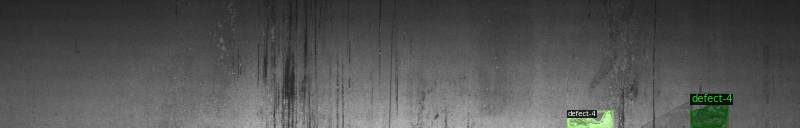

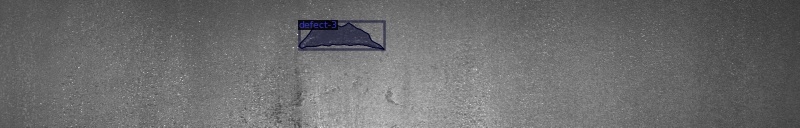

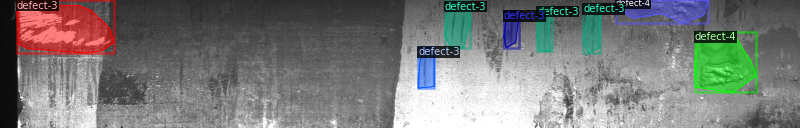

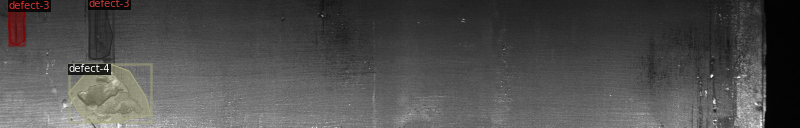

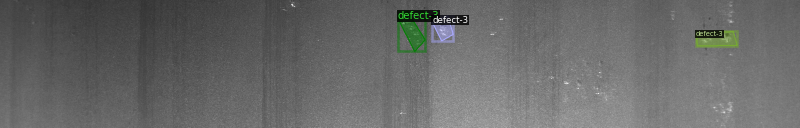

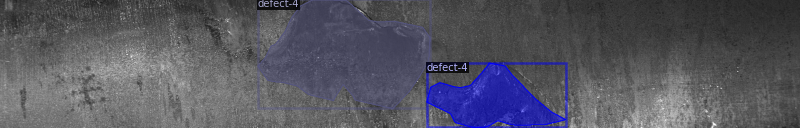

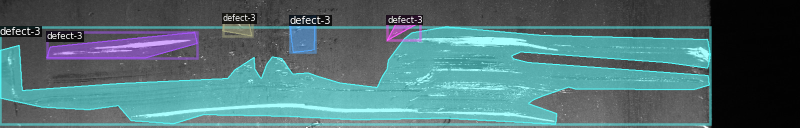

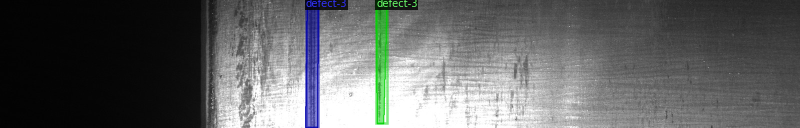

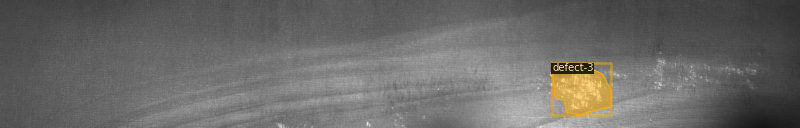

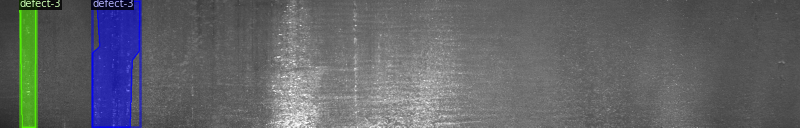

In [33]:
for d in random.sample(dataset_dicts, 10):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=Steel_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1]) 


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



## Train!

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.


In [34]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("Steel_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 2000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # only has one class (Cars)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/05 09:13:55 d2.utils.events]:  eta: 0:01:46  iter: 1319  total_loss: 0.509  loss_cls: 0.093  loss_box_reg: 0.207  loss_mask: 0.196  loss_rpn_cls: 0.003  loss_rpn_loc: 0.017  time: 0.1545  data_time: 0.0046  lr: 0.000250  max_mem: 1630M
[04/05 09:13:58 d2.utils.events]:  eta: 0:01:43  iter: 1339  total_loss: 0.537  loss_cls: 0.077  loss_box_reg: 0.243  loss_mask: 0.196  loss_rpn_cls: 0.005  loss_rpn_loc: 0.037  time: 0.1545  data_time: 0.0041  lr: 0.000250  max_mem: 1630M
[04/05 09:14:01 d2.utils.events]:  eta: 0:01:40  iter: 1359  total_loss: 0.685  loss_cls: 0.109  loss_box_reg: 0.269  loss_mask: 0.224  loss_rpn_cls: 0.006  loss_rpn_loc: 0.042  time: 0.1546  data_time: 0.0049  lr: 0.000250  max_mem: 1630M
[04/05 09:14:04 d2.utils.events]:  eta: 0:01:37  iter: 1379  total_loss: 0.544  loss_cls: 0.083  loss_box_reg: 0.212  loss_mask: 0.194  loss_rpn_cls: 0.004  loss_rpn_loc: 0.018  time: 0.1546  data_time: 0.0043  lr: 0.000250  max_mem: 1630M
[04/05 09:14:08 d2.utils.events]:  eta: 

In [0]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

Launching TensorBoard...

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("Steel_val",)
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

input shape (225, 300, 3)
(180, 240, 3)


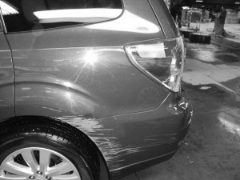

input shape (194, 259, 3)
(155, 207, 3)


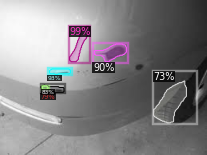

input shape (224, 225, 3)
(179, 180, 3)


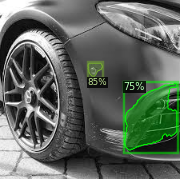

In [0]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_Cars_dicts("Steel/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    print("input shape", im.shape)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=Cars_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    print((v.get_image()[:, :, ::-1]).shape)
    cv2_imshow(v.get_image()[:, :, ::-1])

In [0]:
def infer_model(frame):
  outputs = predictor(frame)
  v = Visualizer(frame[:, :, ::-1],
                  metadata=Cars_metadata, 
                  scale=0.8, 
                  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
  )
  v = v.draw_instance_predictions(outputs["instances"].to("cpu")) 
  img = v.get_image()[:, :, ::-1]
  return img

In [0]:
426//1.25

340.0

In [0]:
import numpy as np
import cv2

cap = cv2.VideoCapture("/content/high res scratch.mp4")
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi',fourcc, 20.0, (int(frame_width//1.25),int(frame_height//1.25)))

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        img = infer_model(frame)
        out.write(img)

        # cv2_imshow(frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70%. Not bad!

In [0]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("Cars_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "Cars_val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

# Other types of builtin models

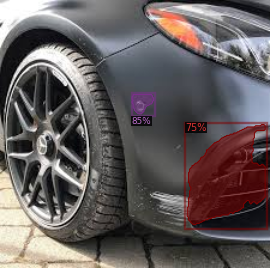

In [0]:
# # Inference with a keypoint detection model
# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
# predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

model_final_cafdb1.pkl: 261MB [00:22, 11.4MB/s]                           


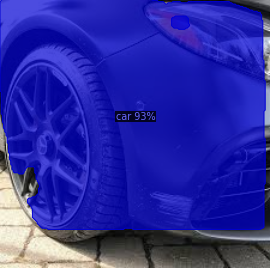

In [0]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(v.get_image()[:, :, ::-1])

# Run panoptic segmentation on a video

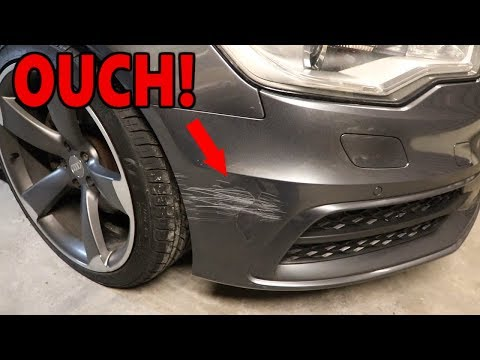

In [0]:
# This is the video we're going to process
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("L8hoOQD6lvg", width=500)
display(video)

In [0]:
!youtube-dl https://www.youtube.com/watch?v=ll8TgCZ0plk -f 22 -o video.mp4

/bin/bash: youtube-dl: command not found


In [0]:
!youtube-dl https://www.youtube.com/watch?v=L8hoOQD6lvg&t -f 22 -o video.mp4

/bin/bash: youtube-dl: command not found
/bin/bash: t: command not found


In [0]:
# Install dependencies, download the video, and crop 5 seconds for processing
# !pip install youtube-dl
# !pip uninstall -y opencv-python opencv-contrib-python
# !apt install python3-opencv  # the one pre-installed have some issues
# !youtube-dl https://www.youtube.com/watch?v=L8hoOQD6lvg&t -f 22 -o video.mp4
!ffmpeg -i video.mp4 -t 00:00:10 -c:v copy video-clip.mp4

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [0]:
path = '/content/output/model_final.pth'

In [0]:
# Run frame-by-frame inference demo on this video (takes 3-4 minutes)
# Using a model trained on COCO dataset
!cd detectron2_repo && python demo/demo.py --config-file configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml --video-input ../video-clip.mp4 --confidence-threshold 0.6 --output ../video-output.mkv \
  --opts MODEL.WEIGHTS '/content/output/model_final.pth'

Failed to load OpenCL runtime
[01/28 10:41:07 detectron2]: Arguments: Namespace(confidence_threshold=0.6, config_file='configs/quick_schedules/mask_rcnn_R_50_FPN_inference_acc_test.yaml', input=None, opts=['MODEL.WEIGHTS', '/content/output/model_final.pth'], output='../video-output.mkv', video_input='../video-clip.mp4', webcam=False)
'roi_heads.box_predictor.cls_score.weight' has shape (2, 1024) in the checkpoint but (81, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (2,) in the checkpoint but (81,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (4, 1024) in the checkpoint but (320, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (4,) in the checkpoint but (320,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (1, 256, 1, 1) in the checkpoint but (80, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (1,) in the checkpoint but (80,) in th

In [0]:
configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml

In [0]:
# Download the results
from google.colab import files
files.download('/content/video-output.mkv')

In [0]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import argparse
import glob
import multiprocessing as mp
import os
import time
import cv2
import tqdm

from detectron2.config import get_cfg
from detectron2.data.detection_utils import read_image
from detectron2.utils.logger import setup_logger

from predictor import VisualizationDemo

# constants
WINDOW_NAME = "COCO detections"


def setup_cfg(args):
    # load config from file and command-line arguments
    cfg = get_cfg()
    cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    # Set score_threshold for builtin models
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = args.confidence_threshold
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = args.confidence_threshold
    cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = args.confidence_threshold
    cfg.freeze()
    return cfg


def get_parser():
    parser = argparse.ArgumentParser(description="Detectron2 demo for builtin models")
    parser.add_argument(
        "--config-file",
        default="configs/quick_schedules/mask_rcnn_R_50_FPN_inference_acc_test.yaml",
        metavar="FILE",
        help="path to config file",
    )
    parser.add_argument("--webcam", action="store_true", help="Take inputs from webcam.")
    parser.add_argument("--video-input", help="Path to video file.")
    parser.add_argument("--input", nargs="+", help="A list of space separated input images")
    parser.add_argument(
        "--output",
        help="A file or directory to save output visualizations. "
        "If not given, will show output in an OpenCV window.",
    )

    parser.add_argument(
        "--confidence-threshold",
        type=float,
        default=0.5,
        help="Minimum score for instance predictions to be shown",
    )
    parser.add_argument(
        "--opts",
        help="Modify config options using the command-line 'KEY VALUE' pairs",
        default=[],
        nargs=argparse.REMAINDER,
    )
    return parser


if __name__ == "__main__":
    mp.set_start_method("spawn", force=True)
    args = get_parser().parse_args()
    logger = setup_logger()
    logger.info("Arguments: " + str(args))

    cfg = setup_cfg(args)

    demo = VisualizationDemo(cfg)

    if args.input:
        if len(args.input) == 1:
            args.input = glob.glob(os.path.expanduser(args.input[0]))
            assert args.input, "The input path(s) was not found"
        for path in tqdm.tqdm(args.input, disable=not args.output):
            # use PIL, to be consistent with evaluation
            img = read_image(path, format="BGR")
            start_time = time.time()
            predictions, visualized_output = demo.run_on_image(img)
            logger.info(
                "{}: detected {} instances in {:.2f}s".format(
                    path, len(predictions["instances"]), time.time() - start_time
                )
            )

            if args.output:
                if os.path.isdir(args.output):
                    assert os.path.isdir(args.output), args.output
                    out_filename = os.path.join(args.output, os.path.basename(path))
                else:
                    assert len(args.input) == 1, "Please specify a directory with args.output"
                    out_filename = args.output
                visualized_output.save(out_filename)
            else:
                cv2.namedWindow(WINDOW_NAME, cv2.WINDOW_NORMAL)
                cv2.imshow(WINDOW_NAME, visualized_output.get_image()[:, :, ::-1])
                if cv2.waitKey(0) == 27:
                    break  # esc to quit
    elif args.webcam:
        assert args.input is None, "Cannot have both --input and --webcam!"
        cam = cv2.VideoCapture(0)
        for vis in tqdm.tqdm(demo.run_on_video(cam)):
            cv2.namedWindow(WINDOW_NAME, cv2.WINDOW_NORMAL)
            cv2.imshow(WINDOW_NAME, vis)
            if cv2.waitKey(1) == 27:
                break  # esc to quit
        cv2.destroyAllWindows()
    elif args.video_input:
        video = cv2.VideoCapture(args.video_input)
        width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
        frames_per_second = video.get(cv2.CAP_PROP_FPS)
        num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        basename = os.path.basename(args.video_input)

        if args.output:
            if os.path.isdir(args.output):
                output_fname = os.path.join(args.output, basename)
                output_fname = os.path.splitext(output_fname)[0] + ".mkv"
            else:
                output_fname = args.output
            assert not os.path.isfile(output_fname), output_fname
            output_file = cv2.VideoWriter(
                filename=output_fname,
                # some installation of opencv may not support x264 (due to its license),
                # you can try other format (e.g. MPEG)
                fourcc=cv2.VideoWriter_fourcc(*"x264"),
                fps=float(frames_per_second),
                frameSize=(width, height),
                isColor=True,
            )
        assert os.path.isfile(args.video_input)
        for vis_frame in tqdm.tqdm(demo.run_on_video(video), total=num_frames):
            if args.output:
                output_file.write(vis_frame)
            else:
                cv2.namedWindow(basename, cv2.WINDOW_NORMAL)
                cv2.imshow(basename, vis_frame)
                if cv2.waitKey(1) == 27:
                    break  # esc to quit
        video.release()
        if args.output:
            output_file.release()
        else:
            cv2.destroyAllWindows()
